In [1]:
# # Standard imports
import random
import pandas as pd
import numpy as np

# # Own Model import
from lib.fl_model_v9 import *
import lib
# # import lib.fl_model_v5 as flm

# # for natural sorting
import re

# #for nondominated sorting
import lib.pareto as pareto
# # from lib.list_imports import find_loaded_modules

# # for parallel plotting
from lib.parallel_plotting import plot_optimal

# # For checking ema running time
import time

import importlib

import geopy
from geopy.distance import great_circle 


In [2]:
import ema_workbench as ema
from ema_workbench.em_framework import (Policy, IntegerParameter, Constant,
                                        RealParameter, ScalarOutcome,
                                        perform_experiments, Model)
from ema_workbench import ema_logging
# from ema_workbench.em_framework.

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
# %load https://gist.github.com/TRomijn/d9d28ba7b7d5eeac1deea5a26dd326b2/raw/loaded_modules.py

'''
original author: kinverarity1

List loaded modules and packages, and show their version numbers
and/or Git repository's HEAD commit SHA.


Changes:
Minor changes to make compatible with Python 3
'''
# Standard library modules
import types
import os

# Third-party packages
import git      # GitPython


def module_path(mod):
    '''Returns path to the file that module *mod* comes from.
    If it doesn't come from a file, return None.'''
    if hasattr(mod, '__file__'):
        return os.path.abspath(os.path.dirname(mod.__file__))
    else:
        return None

    
def from_git_repo(mod):
    '''Does the module *mod* reside in a Git repository?'''
    path = module_path(mod)
    if path:
        try:
            repo = git.Repo(path)
        except:
            return False
        else:
            return True
    else:
        return False

    
def git_path_sha(mod, slice=slice(0, 8, 1)):
    '''Return SHA hash for the HEAD commit for the repository
    that the module *mod* resides in.'''
    repo = git.Repo(module_path(mod))
    return repo.git_dir, repo.head.commit.hexsha[:8]


def module_version(mod):
    '''Return version string for module *mod*, or nothing if
    it doesn't have a "version" or "__version__" attribute.'''
    version = []
    if hasattr(mod, '__dict__'):
        keys = []
        for key in mod.__dict__.keys():
            if key.lower() == 'version' or key.lower() == '__version__':
                v = mod.__dict__[key]
                if isinstance(v, str):
                    version.append(v)
        if keys:
            print (mod, keys)
    if version:
        return ', '.join(version)
    else:
        return ''

    
def find_loaded_modules(only_versioned_modules=True):
    '''Return list of loaded modules for which there is a version
    number or a Git repository commit SHA.
    
    Return a list of *(name, version, path_to_git_repo, git_head_sha)*,
    which has an HTML property for pretty display in IPython Notebooks.
        
    '''
    def list_of_lists_to_HTML(lists, header_row=None):
        '''Convert a list of a list of strings to a HTML table.'''
        s = '<table>'
        if header_row:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<th>%s</th>' % item for item in header_row])
            s += '\n\t</tr>'
        for inner_list in lists:
            s += '\n\t<tr>\n\t\t'
            s += ''.join(['<td>%s</td>' % item for item in inner_list])
            s += '\n\t</tr>'
        s += '\n</table>'
        return s
    
    class LoadedModules(list):
        '''Very simple wrapper for a list of lists of strings, with an attribute
        for display in IPython Notebooks.'''
        def __init__(self, *args, **kwargs):
            list.__init__(self, *args, **kwargs)
            
        @property
        def HTML(self):
            from IPython.display import HTML
            return HTML(
                    list_of_lists_to_HTML(
                            self, header_row=['Name', 'Version', 'Path', 'SHA']))
                    
    objs = LoadedModules()
    for i, mod in enumerate(globals().values()):
        if isinstance(mod, types.ModuleType):
            if hasattr(mod, '__name__'):
                name = mod.__name__
            else:
                name = ''
            
            if from_git_repo(mod):
                path, sha = git_path_sha(mod)
            else:
                path = ''
                sha = ''
            
            version = module_version(mod)
            
            if only_versioned_modules:
                flag = version or (path and sha)
            else:
                flag = True
            
            if flag:
                objs.append([mod.__name__, version, path, sha])
    objs.sort(key=lambda r: r[0])
    return objs


    
    

In [4]:
find_loaded_modules().HTML

In [5]:
case = "Nepal"

# FL Model test

Moved to different Notebook

# FL Model Nepal

## Nepal Data Load


In [6]:
DPs = pd.read_csv("Nepal/Prepared Input Data/DPs.csv")
# DPs.columns

FLs = pd.read_csv("Nepal/Prepared Input Data/FLs.csv")
# FLs.columns

SPs = pd.read_csv("Nepal/Prepared Input Data/SPs.csv")
# SPs.columns
Fix_Unc = pd.read_csv("{}/Prepared Input Data/fixed_uncertainties.csv".format(case), index_col=0)
Fix_Unc

lower  best_estimate  upper
var                                             
unit_opening_costs    50.0            100    200
unit_transport_cost    0.5              1      2
FL_operations_cost    20.0             30     50
FL_range               2.0              4      6
demand_per_affected   10.0             20     50

## Nepal Instantiation 

In [7]:
# 0. Instantiate

# General
# Coordinates
# all large cities to demand points
DPY = {"DPY{}".format(i): y for i,y in enumerate(DPs['latitude'])}
DPX = {"DPX{}".format(i): x for i,x in enumerate(DPs['longitude'])}

# all international airports to supply points:
SPY = {"SPY{}".format(i): y for i,y in enumerate(SPs['latitude_deg'])}
SPX = {"SPX{}".format(i): x for i,x in enumerate(SPs['longitude_deg'])}

# Facility locations
FLX = {"FLX{}".format(i): x for i,x in enumerate(FLs['Lon'])}
FLY = {"FLY{}".format(i): y for i,y in enumerate(FLs['Lat'])}


# Population demand points
DPpop = {"DPpop{}".format(i): pop for i,pop in enumerate(DPs['population'])}
# DPpop = {"DPpop{}".format(i): random.uniform(10,100) for i in range(nr_of_DPs)}


## Create distance matrix

In [8]:
# node_names = ["SP{}".format(i) for i, ind in enumerate(SPs.index)] + [
#     "FL{}".format(i) for i, ind in enumerate(FLs.index)
# ] + ["DP{}".format(i) for i, ind in enumerate(DPs.index)]

## Disruptions

In [9]:
epicentre_name = "RealLocation"

In [10]:
disruptionsFLs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionFL{}.txt'.format(epicentre_name))
disruptionsDPs = np.loadtxt(
    'Nepal/Prepared Input Data/DisruptionDP{}.txt'.format(epicentre_name))

In [11]:
# Base real values on Nepal earthquake
# DSR is abbreviation for Disruption

DSRDP = {"DSRDP{}".format(i): disruptionsDPs[i] for i in range(len(DPX))}
DSRFL = {"DSRFL{}".format(i): disruptionsFLs[i] for i in range(len(FLX))}

# Multi-Objective Optimisation Framework

Pseudocode:

    Current situation
    Create possible options (full factorial)
    Evaluate all possible options
    Check pareto front of outcomes

## Optimisation single period 

In [12]:
start_situation = {key:0 for key in FLs.Name}

In [13]:
from itertools import product

In [14]:
permutations = [i for i in product([0,1],repeat=len(FLs)) if sum(i) ==4]

In [15]:
len(permutations)

4845

In [16]:
All_optional_pols = []

for p in permutations:
    tmp = {"FLO{}".format(i):val for i,val in enumerate(p)}
    All_optional_pols.append(tmp)

In [17]:
len(All_optional_pols)

4845

## policies: FLs one for one

In [18]:
# %%timeit
# Evaluate all optional policies with best estimate values
best_est_results_opt_pols = []
for policy in All_optional_pols:
    best_est_results_opt_pols.append(
        FL_model(
            unit_opening_costs=Fix_Unc.best_estimate['unit_opening_costs'],
            unit_transport_cost=Fix_Unc.best_estimate['unit_transport_cost'],
            FL_operations_cost=Fix_Unc.best_estimate['FL_operations_cost'],
            demand_per_affected=Fix_Unc.best_estimate['demand_per_affected'],
            graphical_representation=False,
            FL_range=Fix_Unc.best_estimate['FL_range'],
            dist_method='from_table',
            table_dir="{}/Prepared Input Data/routing_table.csv".format(case),
            **SPX,
            **SPY,
            **DPX,
            **DPY,
            **FLX,
            **FLY,
            **policy,
            **DSRDP,
            **DSRFL,
            **DPpop))

In [19]:
best_est_results_opt_pols

[(31238.870120752716, 23, 15821.17852095118, 60233.99, False, None),
 (48254.43158545064, 22, 14259.054650637372, 60233.99, False, None),
 (51196.006642538974, 21, 14245.85305828652, 61178.67, False, None),
 (47450.084698801365, 21, 14245.85305828652, 60233.99, True, None),
 (44536.94286832907, 22, 14391.742773481834, 78002.77692815893, False, None),
 (30191.277361006894, 24, 15834.380113302032, 59777.42, False, None),
 (30996.66452062782, 23, 15821.17852095118, 59777.42, False, None),
 (29812.6321668822, 23, 15821.17852095118, 59777.42, True, None),
 (26899.490336409915, 24, 15967.068236146493, 78002.77692815893, False, None),
 (47765.40181288449, 22, 14259.054650637372, 59777.42, False, None),
 (46581.36945913888, 22, 14259.054650637372, 59777.42, True, None),
 (43668.227628666595, 23, 14404.944365832685, 78002.77692815893, False, None),
 (47386.75661875982, 21, 14245.85305828652, 59777.42, True, None),
 (44473.61478828752, 22, 14391.742773481834, 78002.77692815893, False, None),
 (4

## Original from here

In [20]:
# outcome indicators, as internally used by the model
oois = [
    'total_costs', 'nr_uncovered_DPs', 'total_uncovered_demand',
    'max_travel_time'
]
# Put outcomes in DF

df_best_est_results_opt_pols = pd.DataFrame(
    np.asarray(best_est_results_opt_pols)[:, :5],
    columns=oois + ["constraint"])
df_best_est_results_opt_pols.tail()

total_costs nr_uncovered_DPs total_uncovered_demand max_travel_time  \
4840      285220               11                5143.11         32243.6   
4841      240420               17                7545.95         50648.8   
4842      240420               17                7545.95         42263.5   
4843      240420               17                7545.95         50648.8   
4844      221572               17                7545.95         50648.8   

     constraint  
4840       True  
4841      False  
4842      False  
4843      False  
4844       True

In [21]:
# constraint
df_best_est_results_opt_pols = df_best_est_results_opt_pols[df_best_est_results_opt_pols.constraint == 1]

df_best_est_results_opt_pols = df_best_est_results_opt_pols[oois]

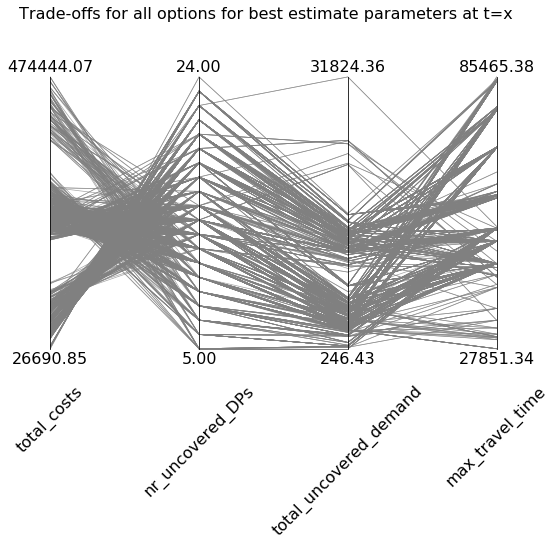

In [22]:
title = "Trade-offs for all options for best estimate parameters at t=x"
plot_optimal(df_best_est_results_opt_pols, oois, title)

In [23]:
# options for pareto sorting# minimising is default
kwargs = {"maximize_all": True}
kwargs2 = {"maximize": [0, 1]}

nondominated_BE_policy_results = np.array(pareto.eps_sort(
    [list(df_best_est_results_opt_pols.itertuples(index=True))], [1, 2, 3, 4],
    [1e-9, 1e-9, 1e-9, 1e-9]))

#Filter out those where new demand is covered
# nondominated_BE_policy_results = nondominated_BE_policy_results[nondominated_BE_policy_results[:,4] != 0]

# Put outcomes in DF
df_nondominated_BE_policy_results = pd.DataFrame(
    np.asarray(nondominated_BE_policy_results),
    columns=["pol_i"] + oois).set_index("pol_i")
df_nondominated_BE_policy_results.head(5)

total_costs  nr_uncovered_DPs  total_uncovered_demand  \
pol_i                                                            
12.0    47386.756619              21.0            14245.853058   
48.0   210170.847036              14.0             4799.795364   
51.0   226939.584329              13.0             3237.671494   
58.0   222228.415819              12.0             4072.727679   
93.0    65039.834230              17.0            12247.090789   

       max_travel_time  
pol_i                   
12.0      59777.420000  
48.0      45920.157395  
51.0      45920.157395  
58.0      45920.157395  
93.0      45920.157395

In [24]:
df_nondominated_BE_policy_results.shape

(72, 4)

In [25]:
nondominated_BE_policy_results

array([[1.20000000e+01, 4.73867566e+04, 2.10000000e+01, 1.42458531e+04,
        5.97774200e+04],
       [4.80000000e+01, 2.10170847e+05, 1.40000000e+01, 4.79979536e+03,
        4.59201574e+04],
       [5.10000000e+01, 2.26939584e+05, 1.30000000e+01, 3.23767149e+03,
        4.59201574e+04],
       [5.80000000e+01, 2.22228416e+05, 1.20000000e+01, 4.07272768e+03,
        4.59201574e+04],
       [9.30000000e+01, 6.50398342e+04, 1.70000000e+01, 1.22470908e+04,
        4.59201574e+04],
       [1.23000000e+02, 2.29031638e+05, 1.00000000e+01, 2.63606973e+03,
        7.05835149e+04],
       [3.43000000e+02, 4.85872791e+04, 1.90000000e+01, 1.38261458e+04,
        5.97774200e+04],
       [3.68000000e+02, 2.31778331e+05, 1.00000000e+01, 2.80476269e+03,
        4.59201574e+04],
       [3.75000000e+02, 2.28140107e+05, 1.10000000e+01, 2.81796428e+03,
        4.59201574e+04],
       [3.78000000e+02, 2.24848320e+05, 1.10000000e+01, 2.95065241e+03,
        7.04882245e+04],
       [3.83000000e+02, 2.3329

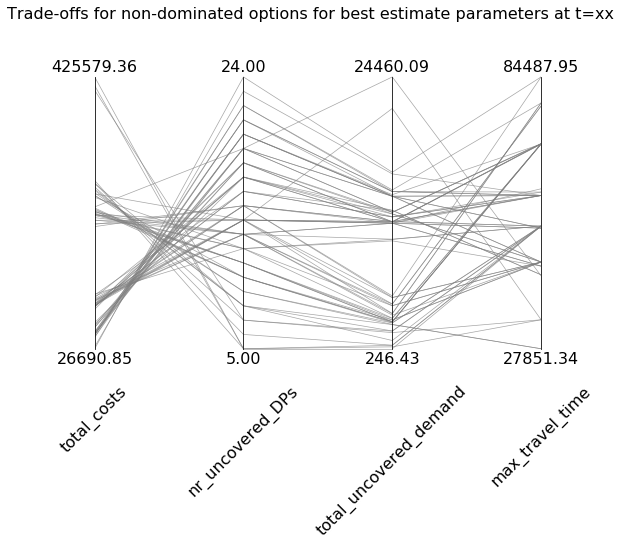

In [26]:
title = "Trade-offs for non-dominated options for best estimate parameters at t=xx"
plot_optimal(df_nondominated_BE_policy_results, oois, title)

In [27]:
# policies for all nondominated policies
nondom_i = [int(a[0]) for a in nondominated_BE_policy_results]

nondominated_BE_policies = np.array(All_optional_pols)[nondom_i]
nondominated_BE_policies.shape

(72,)

In [31]:
## If skipping robustness testing and filtering
# import pickle

# # Store data (serialize)
# with open('{}/MOO/rob_nondom_pols_test3_norobustnessfilter.pickle'.format(case),
#           'wb') as handle:
#     pickle.dump(
#         (nondominated_BE_policies),
#         handle,
#         protocol=pickle.HIGHEST_PROTOCOL)

#### visualise all nondom pols

In [45]:
all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}


In [46]:
tmp = [[key for key,val in pol.items() if val == 1] for pol in np.array(All_optional_pols)[nondom_i]]

In [47]:
flat_list = [item for sublist in tmp for item in sublist]

In [48]:
set(flat_list)

{'FLO1',
 'FLO11',
 'FLO12',
 'FLO13',
 'FLO14',
 'FLO15',
 'FLO16',
 'FLO19',
 'FLO3',
 'FLO4',
 'FLO7',
 'FLO8',
 'FLO9'}

In [49]:
"This doesn't work for MOO"

# # inspect nondominated results

# all_nondom_BE_pols = {name:1 if pos_i in nondom_i else 0 for pos_i, name in enumerate(FLs['Name'])}

# a = FL_model(
#     unit_opening_costs = 1,
#     unit_transport_cost= 1, #cost per hour/ dollar or euroXX
#     FL_operations_cost = 10,
#     demand_per_affected = 1, # units per 1000 affected people
#     graphical_representation = True,
#     FL_range=4, # in hours. km? --> meters
#     dist_method="from_table", #"great_circle",
#     table_dir = "Nepal/Prepared Input Data/routing_table.csv",
#     lorry_speed="nope", #km/h? -->m/s
#     **SPX,
#     **SPY,
#     **DPX,
#     **DPY,
#     **FLX,
#     **FLY,
#     **all_nondom_BE_pols,
#     **DSRDP,
#     **DSRFL,
#     **DPpop)
# print("These are all the FLs that are in the set of non-dominated policies")
# a[5]

"This doesn't work for MOO"

# EMA Framework

## EMA instantiations

In [56]:
models = []
t = 0
model = Model("flmodelt{}".format(t), FL_model)

model.locations = [
    Constant("DPX{}".format(i), x)
    for i, x in zip(DPs.index, DPs['longitude'])
] + [
    Constant("DPY{}".format(i), y)
    for i, y in zip(DPs.index, DPs['latitude'])
] + [
    Constant("SPX{}".format(i), x)
    for i, x in zip(SPs.index, SPs['longitude_deg'])
] + [
    Constant("SPY{}".format(i), y)
    for i, y in zip(SPs.index, SPs['latitude_deg'])
] + [Constant("FLX{}".format(i), x) for i, x in zip(FLs.index, FLs['Lon'])] + [
    Constant("FLY{}".format(i), y) for i, y in zip(FLs.index, FLs['Lat'])
]

# Reachability of Demand Points and Facility Locations can be disrupted
# Disruption also determines demand (disr-1)*pop
model.disruptions = [Constant(key,val) for key,val in DSRDP.items()] + [Constant(key,val) for key,val in DSRFL.items()]


model.constants = [
    Constant('graphical_representation', False),
    Constant('dist_method', 'from_table'),
    Constant('table_dir', 'Nepal/Prepared Input Data/routing_table.csv')
    #list of other constants
] + model.locations + [  # population DPs
    Constant("DPpop{}".format(i), pop)
    for i, pop in zip(DPs.index, DPs['population'])
] + model.disruptions


model.uncertainties = [
    RealParameter('unit_opening_costs', 
                  Fix_Unc.lower['unit_opening_costs'],
                  Fix_Unc.upper['unit_opening_costs']),
    RealParameter('unit_transport_cost',
                  Fix_Unc.lower['unit_transport_cost'],
                  Fix_Unc.upper['unit_transport_cost']),  # #cost per hour/ dollar or euroXX
    RealParameter('FL_operations_cost',
                  Fix_Unc.lower['FL_operations_cost'],
                  Fix_Unc.upper['FL_operations_cost']),
    RealParameter('FL_range',
                  Fix_Unc.lower['FL_range'],
                  Fix_Unc.upper['FL_range']),  # km TODO: great circle distance
    RealParameter('demand_per_affected',
                  Fix_Unc.lower['demand_per_affected'],
                  Fix_Unc.upper['demand_per_affected']),  #units per 1000 affected people
    #list of other uncertainties
] #+ model.disruptions  #+ model.locations_uncertain

model.outcomes = [
    ScalarOutcome("total_costs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("nr_uncovered_DPs", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("total_uncovered_demand", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome(
        "max_travel_time",
        kind=ScalarOutcome.MINIMIZE,
    )
]

models.append(model)

In [57]:
if [o.name for o in models[0].outcomes] != oois:
    print("Watch out! Oois and model outcome names are not similar!")

In [58]:
for model in models:
    print(model.name)

flmodelt0


In [59]:
nondominated_BE_policies_EMA = []
for name, pol in zip(nondom_i,nondominated_BE_policies):
    nondominated_BE_policies_EMA.append(Policy("{}".format(name), **pol))

In [60]:
time1 = time.time()
all_scen_results_nondom_pols = perform_experiments(model,100,nondominated_BE_policies_EMA)
time2 = time.time()
print("Total time:{}".format(time2-time1),"\n","time per run = {}".format((time2-time1)/1000))

[MainProcess/INFO] performing 100 scenarios * 72 policies * 1 model(s) = 7200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2880 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4320 cases completed
[MainProcess/INFO] 5040 cases completed
[MainProcess/INFO] 5760 cases completed
[MainProcess/INFO] 6480 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] experiments finished


Total time:82.85135579109192 
 time per run = 0.08285135579109192


timelog: (3000 experiments)
1. possibly with cpu problems due to failed multiprocessing <br>
Total time:186.64591431617737 <br>
time per run = 0.18664591431617736
2. model v2 <br>
Total time:156.22968077659607  <br>
 time per run = 0.15622968077659607
3. model v2 4 policies <br>
Total time:200.71212720870972 
 time per run = 0.2007121272087097
4. 
Total time:144.36057209968567 <br>
 time per run = 0.14436057209968567
 
5. 
Total time:69.68182039260864 <br>
 time per run = 0.06968182039260865
 
6. 5000 experiments <br>
time per run = 0.03758887338638306

In [61]:
# Add parameter in filename for period t=1,2...x
ema.save_results(all_scen_results_nondom_pols,
                 "{}/MOO/candidate_policy_robustness_test2.tar.gz".format(case))

[MainProcess/INFO] results saved successfully to C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MOO\candidate_policy_robustness_test2.tar.gz


# Robustness Framework

In [62]:
all_scen_results_nondom_pols = ema.load_results(
    "{}/MOO/candidate_policy_robustness_test2.tar.gz".format(case))
experiments, outcomes = all_scen_results_nondom_pols

[MainProcess/INFO] results loaded succesfully from C:\Users\timro\Dropbox\MSc EPA\0 Master Thesis\Python Files\Thesis\Facility Location Model\Nepal\MOO\candidate_policy_robustness_test2.tar.gz


In [63]:
experiments

array([(20.04000491, 4.85094124, 16.20897194,  50.10049539, 1.99914464, 0, 12, 'flmodelt0'),
       (37.92424654, 5.72497187, 26.26952731, 159.7785917 , 1.12706062, 1, 12, 'flmodelt0'),
       (33.04371799, 3.19411941, 34.11586447,  80.7008081 , 1.13292829, 2, 12, 'flmodelt0'),
       ...,
       (40.83367435, 2.24035733, 14.30537935, 170.86606545, 1.02513051, 97, 3633, 'flmodelt0'),
       (42.81192118, 4.78860805, 29.85331153, 106.28035754, 1.02296241, 98, 3633, 'flmodelt0'),
       (29.87838114, 2.17292484, 10.5869804 , 131.78737003, 1.04131476, 99, 3633, 'flmodelt0')],
      dtype=[('FL_operations_cost', '<f8'), ('FL_range', '<f8'), ('demand_per_affected', '<f8'), ('unit_opening_costs', '<f8'), ('unit_transport_cost', '<f8'), ('scenario_id', 'O'), ('policy', 'O'), ('model', 'O')])

In [64]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    return score

sigN_results = []

for policy in nondominated_BE_policies_EMA:
    #filter the outcome values corresponding to each policy using a logical index
    logical_index = experiments['policy']==int(policy.name)
    pol_outcomes = {key:outcomes[key][logical_index] for key in outcomes.keys()}
    temp_result = {}
    for ooi in models[0].outcomes:
        temp_result[ooi.name] = calculate_signalNoise(pol_outcomes[ooi.name], ooi.kind)
    sigN_results.append(temp_result)    


In [65]:
df_sigN = pd.DataFrame(sigN_results, index=[pol.name for pol in nondominated_BE_policies_EMA])
df_sigN

max_travel_time  nr_uncovered_DPs   total_costs  total_uncovered_demand
12       59778.420000        106.573329  4.969275e+09            1.874872e+08
48       45921.157395         73.228998  8.796832e+10            3.521162e+07
51       45921.157395         68.686355  9.769588e+10            2.699319e+07
58       45921.157395         60.269213  9.927803e+10            2.069295e+07
93       45921.157395         97.726828  1.226662e+10            1.305417e+08
123      70584.514874         44.684735  9.745999e+10            1.641989e+07
343      59778.420000         82.089069  4.941786e+09            1.762008e+08
368      45921.157395         53.570039  1.013879e+11            2.331543e+07
375      45921.157395         51.949400  9.859202e+10            2.251381e+07
378      70489.224518         49.678811  9.438214e+10            2.361749e+07
383      70489.224518         34.796324  1.018212e+11            1.311010e+07
514      59778.420000         97.764052  1.518837e+10            1.398573e+08
518      45071.660001        104.378217  2.748957e+10            1.096483e+08
533      27852.337183         58.467247  1.282346e+11            2.042601e+07
540      27852.337183         57.580110  1.257777e+11            1.890565e+07
543      53410.117994         60.887476  1.228011e+11            1.989032e+07
544      53410.117994         54.656552  1.342829e+11            1.344398e+07
545      33887.375193         71.679050  3.029844e+11            8.879673e+07
548      53410.117994         47.038124  1.361331e+11            9.220556e+06
554      52978.890000         81.391124  2.208051e+10            1.101715e+08
566      45071.660001        121.520892  1.215966e+11            2.665919e+08
569      53410.117994         85.132784  2.647493e+10            9.319095e+07
572      33887.375193         64.686374  3.143603e+11            1.010769e+08
578      53410.117994         64.754258  3.027930e+11            7.724928e+07
636      43041.741440         85.488678  1.213558e+11            4.913798e+08
663      61179.670000         79.262727  1.722612e+10            1.283450e+08
670      59778.420000         78.246950  1.632266e+10            1.268678e+08
673      59778.420000         78.253855  1.530462e+10            1.297549e+08
681      33887.375193        101.382138  2.792771e+11            4.487450e+08
684      53410.117994         42.398503  1.386256e+11            1.100448e+07
...               ...               ...           ...                     ...
1865     45921.157395         73.619653  8.727248e+10            3.521828e+07
1868     84488.954938         67.654275  8.325329e+10            3.642188e+07
1869     79058.995030         65.044818  9.274931e+10            2.815159e+07
1870     45921.157395         60.732482  9.660795e+10            2.070226e+07
1873     78426.288271         56.727731  9.220969e+10            2.168817e+07
1875     78426.288271         56.980782  9.049298e+10            2.147297e+07
1879     52978.890000         90.943829  7.687404e+09            1.561634e+08
1886     52978.890000         91.463560  7.631576e+09            1.561840e+08
1891     45921.157395         98.124351  1.140435e+10            1.305681e+08
1894     70584.514874         91.015694  9.766385e+09            1.335891e+08
1896     70584.514874         91.174619  9.704160e+09            1.336052e+08
1903     70584.514874         44.550973  9.481027e+10            1.642437e+07
1995     59778.420000         82.287775  4.782844e+09            1.762180e+08
1998     70489.224518         70.781284  3.813337e+09            1.805137e+08
2011     70489.224518         49.624503  9.365826e+10            2.362033e+07
2012     70489.224518         34.651548  9.910413e+10            1.311449e+07
2019     70489.224518         78.896941  1.056236e+10            1.278263e+08
2049     60500.990001         98.038574  1.501133e+10            1.413956e+08
2054     59778.420000         97.898004  1.490661e+10            1.398716e+08
2055     45071.660001       

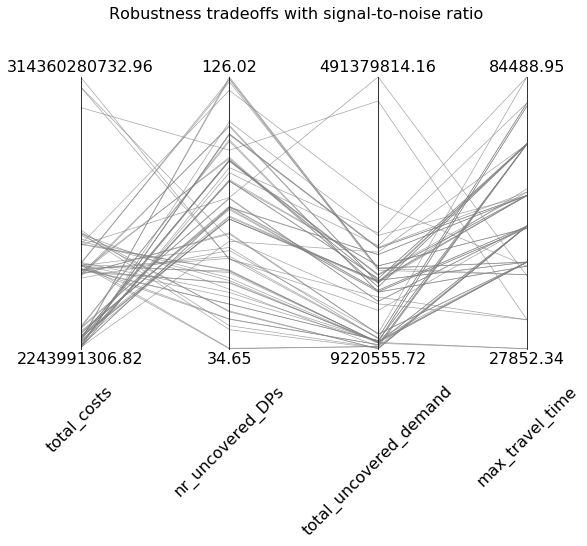

In [66]:

title = "Robustness tradeoffs with signal-to-noise ratio"
plot_optimal(df_sigN, oois, title)

In [67]:
def calculate_maxregret(data, obj):
    '''
    data : a list of 1d arrays whose shape is no_policies x no_scenarios
    obj : -1 or 1, the objective 
    '''
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        #find the best case in each scenario, therefore use the max function of numpy on the axis of policies
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    
    #determine the regret values for eaxh policy in each scenario
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(data.shape[0])]
    
    max_regrets = np.max(regrets, axis=1)
    
    return max_regrets

In [68]:
reg_results = {}
# we need to iterate over the outcomes differently now, 
#because the maximum egret calculation requires the outcome values for all policies
for ooi in models[0].outcomes:
    data = []
    for policy in nondominated_BE_policies_EMA:
        logical_index = experiments['policy'] == int(policy.name) 
        data.append(outcomes[ooi.name][logical_index])
    reg_results[ooi.name] = calculate_maxregret(data, ooi.kind)
    


In [69]:
reg_results

{'total_costs': array([  81878.39567015,  825974.88813816,  883682.50550475,
         871388.01574846,  275026.62548718,  910881.41754198,
          98566.3913327 ,  923246.33553447,  907283.01653193,
         892049.17086497,  930089.35517739,  263530.90025528,
         459766.42514439, 1045737.07275741, 1029773.75375487,
        1014539.90808792, 1072247.52545451, 1691815.49835699,
        1052580.09240033,  359186.5893453 , 1004846.88727991,
         439560.66621819, 1796104.74937671, 1738681.8434484 ,
        1040578.48647324,  318328.57595195,  302365.25694941,
         287131.41128246, 2125167.09323391, 1111811.35548423,
        1095848.03648169, 1133908.2443746 , 1152139.09907604,
        1226640.29279027, 1208395.15490306,   82974.93885184,
          39719.08539006,   78409.09358061,   60262.80505258,
         281072.4417913 ,  262641.84124772,  867910.67546579,
         822123.09396728,  806889.24830033,  864596.86566692,
         858203.14117848,  841968.50947726,  832592.713

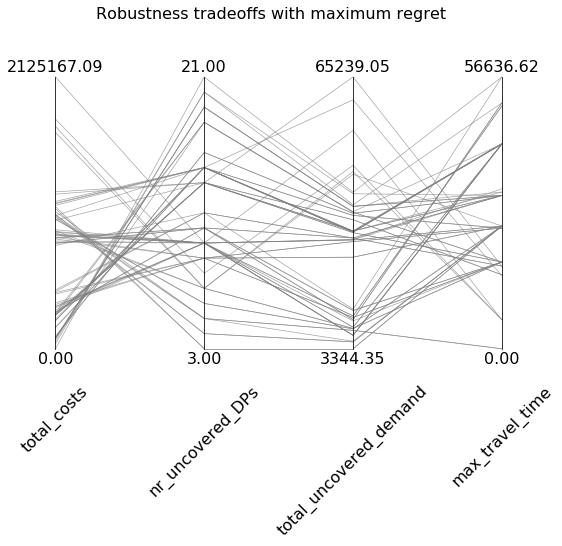

In [70]:
# we can again convert the robustness values into a dataframe. 
#However, since the results are in a dictionary, we need to do it differently.
df_regret = pd.DataFrame.from_dict(reg_results, orient='columns',)
df_regret.index = [pol.name for pol in nondominated_BE_policies_EMA]
title = "Robustness tradeoffs with maximum regret"
plot_optimal(df_regret, oois, title)

## Choose nondominated robust policies

In [71]:
df_regret

total_costs  nr_uncovered_DPs  total_uncovered_demand  max_travel_time
12    8.187840e+04              19.0            35761.009997     31926.082817
48    8.259749e+05              11.0            12053.301003     18068.820212
51    8.836825e+05              10.0             9671.563549     18068.820212
58    8.713880e+05               9.0            10456.394153     18068.820212
93    2.750266e+05              14.0            29783.335025     18068.820212
123   9.108814e+05              10.0             6380.080619     42732.177691
343   9.856639e+04              16.0            34180.144256     31926.082817
368   9.232463e+05               7.0             7967.061996     18068.820212
375   9.072830e+05               7.0             7967.061996     18068.820212
378   8.920492e+05              10.0             8265.874267     42636.887336
383   9.300894e+05              10.0             6380.080619     42636.887336
514   2.635309e+05              14.0            30165.837658     31926.082817
518   4.597664e+05              12.0            28541.350238     17219.322817
533   1.045737e+06               5.0             7536.437834         0.000000
540   1.029774e+06               5.0             7536.437834         0.000000
543   1.014540e+06               6.0             7869.765639     25557.780811
544   1.072248e+06               5.0             5048.853292     25557.780811
545   1.691815e+06               7.0            43692.538934      6035.038010
548   1.052580e+06               4.0             4906.140152     25557.780811
554   3.591866e+05               9.0            27741.094276     25126.552817
566   1.004847e+06              14.0            65239.047122     17219.322817
569   4.395607e+05               9.0            24188.162685     25557.780811
572   1.796105e+06               8.0            45114.979561      6035.038010
578   1.738682e+06               7.0            43077.819770     25557.780811
636   1.040578e+06              15.0            60027.602637     15189.404256
663   3.183286e+05              10.0            28196.469343     33327.332817
670   3.023653e+05              10.0            28196.469343     31926.082817
673   2.871314e+05              11.0            28575.973067     31926.082817
681   2.125167e+06              10.0            53069.763347      6035.038010
684   1.111811e+06               3.0             3344.351739     25557.780811
...            ...               ...                     ...              ...
1865  8.221231e+05              11.0            12053.301003     18068.820212
1868  8.068892e+05              12.0            12352.113275     56636.617754
1869  8.645969e+05              11.0             9970.375821     51206.657846
1870  8.582031e+05               9.0            10456.394153     18068.820212
1873  8.419685e+05              10.0            10815.162909     50573.951087
1875  8.325927e+05              10.0            10815.162909     50573.951087
1879  1.660063e+05              15.0            33697.938895     25126.552817
1886  1.651697e+05              15.0            33697.938895     25126.552817
1891  2.624450e+05              14.0            29783.335025     18068.820212
1894  2.199974e+05              15.0            30145.007305     42732.177691
1896  2.190150e+05              15.0            30145.007305     42732.177691
1903  8.969593e+05              10.0             6380.080619     42732.177691
1995  9.471460e+04              16.0            34180.144256     31926.082817
1998  7.948075e+04              18.0            34559.647980     42636.887336
2011  8.881974e+05              10.0             8265.874267     42636.887336
2012  9.161673e+05              10.0             6380.080619     42636.887336
2019  2.307817e+05              15.0            30145.007305     42636.887336
2049  2.629929e+05              14.0            30165.837658     32648.652817
2054  2.596791e+05              14.0            30165.837658     31926.082817
2055  4.471848e+05           

In [72]:
df_sigN

max_travel_time  nr_uncovered_DPs   total_costs  total_uncovered_demand
12       59778.420000        106.573329  4.969275e+09            1.874872e+08
48       45921.157395         73.228998  8.796832e+10            3.521162e+07
51       45921.157395         68.686355  9.769588e+10            2.699319e+07
58       45921.157395         60.269213  9.927803e+10            2.069295e+07
93       45921.157395         97.726828  1.226662e+10            1.305417e+08
123      70584.514874         44.684735  9.745999e+10            1.641989e+07
343      59778.420000         82.089069  4.941786e+09            1.762008e+08
368      45921.157395         53.570039  1.013879e+11            2.331543e+07
375      45921.157395         51.949400  9.859202e+10            2.251381e+07
378      70489.224518         49.678811  9.438214e+10            2.361749e+07
383      70489.224518         34.796324  1.018212e+11            1.311010e+07
514      59778.420000         97.764052  1.518837e+10            1.398573e+08
518      45071.660001        104.378217  2.748957e+10            1.096483e+08
533      27852.337183         58.467247  1.282346e+11            2.042601e+07
540      27852.337183         57.580110  1.257777e+11            1.890565e+07
543      53410.117994         60.887476  1.228011e+11            1.989032e+07
544      53410.117994         54.656552  1.342829e+11            1.344398e+07
545      33887.375193         71.679050  3.029844e+11            8.879673e+07
548      53410.117994         47.038124  1.361331e+11            9.220556e+06
554      52978.890000         81.391124  2.208051e+10            1.101715e+08
566      45071.660001        121.520892  1.215966e+11            2.665919e+08
569      53410.117994         85.132784  2.647493e+10            9.319095e+07
572      33887.375193         64.686374  3.143603e+11            1.010769e+08
578      53410.117994         64.754258  3.027930e+11            7.724928e+07
636      43041.741440         85.488678  1.213558e+11            4.913798e+08
663      61179.670000         79.262727  1.722612e+10            1.283450e+08
670      59778.420000         78.246950  1.632266e+10            1.268678e+08
673      59778.420000         78.253855  1.530462e+10            1.297549e+08
681      33887.375193        101.382138  2.792771e+11            4.487450e+08
684      53410.117994         42.398503  1.386256e+11            1.100448e+07
...               ...               ...           ...                     ...
1865     45921.157395         73.619653  8.727248e+10            3.521828e+07
1868     84488.954938         67.654275  8.325329e+10            3.642188e+07
1869     79058.995030         65.044818  9.274931e+10            2.815159e+07
1870     45921.157395         60.732482  9.660795e+10            2.070226e+07
1873     78426.288271         56.727731  9.220969e+10            2.168817e+07
1875     78426.288271         56.980782  9.049298e+10            2.147297e+07
1879     52978.890000         90.943829  7.687404e+09            1.561634e+08
1886     52978.890000         91.463560  7.631576e+09            1.561840e+08
1891     45921.157395         98.124351  1.140435e+10            1.305681e+08
1894     70584.514874         91.015694  9.766385e+09            1.335891e+08
1896     70584.514874         91.174619  9.704160e+09            1.336052e+08
1903     70584.514874         44.550973  9.481027e+10            1.642437e+07
1995     59778.420000         82.287775  4.782844e+09            1.762180e+08
1998     70489.224518         70.781284  3.813337e+09            1.805137e+08
2011     70489.224518         49.624503  9.365826e+10            2.362033e+07
2012     70489.224518         34.651548  9.910413e+10            1.311449e+07
2019     70489.224518         78.896941  1.056236e+10            1.278263e+08
2049     60500.990001         98.038574  1.501133e+10            1.413956e+08
2054     59778.420000         97.898004  1.490661e+10            1.398716e+08
2055     45071.660001       

In [73]:
all_robustness_scores = pd.merge(df_regret,df_sigN, left_index=True, right_index=True, suffixes=('_regret', '_sigN'))

In [74]:
all_robustness_scores

total_costs_regret  nr_uncovered_DPs_regret  \
12          8.187840e+04                     19.0   
48          8.259749e+05                     11.0   
51          8.836825e+05                     10.0   
58          8.713880e+05                      9.0   
93          2.750266e+05                     14.0   
123         9.108814e+05                     10.0   
343         9.856639e+04                     16.0   
368         9.232463e+05                      7.0   
375         9.072830e+05                      7.0   
378         8.920492e+05                     10.0   
383         9.300894e+05                     10.0   
514         2.635309e+05                     14.0   
518         4.597664e+05                     12.0   
533         1.045737e+06                      5.0   
540         1.029774e+06                      5.0   
543         1.014540e+06                      6.0   
544         1.072248e+06                      5.0   
545         1.691815e+06                      7.0   
548         1.052580e+06                      4.0   
554         3.591866e+05                      9.0   
566         1.004847e+06                     14.0   
569         4.395607e+05                      9.0   
572         1.796105e+06                      8.0   
578         1.738682e+06                      7.0   
636         1.040578e+06                     15.0   
663         3.183286e+05                     10.0   
670         3.023653e+05                     10.0   
673         2.871314e+05                     11.0   
681         2.125167e+06                     10.0   
684         1.111811e+06                      3.0   
...                  ...                      ...   
1865        8.221231e+05                     11.0   
1868        8.068892e+05                     12.0   
1869        8.645969e+05                     11.0   
1870        8.582031e+05                      9.0   
1873        8.419685e+05                     10.0   
1875        8.325927e+05                     10.0   
1879        1.660063e+05                     15.0   
1886        1.651697e+05                     15.0   
1891        2.624450e+05                     14.0   
1894        2.199974e+05                     15.0   
1896        2.190150e+05                     15.0   
1903        8.969593e+05                     10.0   
1995        9.471460e+04                     16.0   
1998        7.948075e+04                     18.0   
2011        8.881974e+05                     10.0   
2012        9.161673e+05                     10.0   
2019        2.307817e+05                     15.0   
2049        2.629929e+05                     14.0   
2054        2.596791e+05                     14.0   
2055        4.471848e+05                     12.0   
2066        1.010688e+06                      6.0   
2067        1.038658e+06                      4.0   
2068        3.460017e+05                      9.0   
2071        3.297671e+05                     10.0   
2073        3.287375e+05                     10.0   
2074        4.269790e+05                      9.0   
2100        2.832796e+05                     11.0   
2309        1.120723e+06                     15.0   
2336        1.138954e+06                     15.0   
3633        0.000000e+00                     21.0   

      total_uncovered_demand_regret  max_travel_time_regret  \
12                     35761.009997            31926.082817   
48                     12053.301003            18068.820212   
51                      9671.563549            18068.820212   
58                     10456.394153            18068.820212   
93                     29783.335025            18068.820212   
123                     6380.080619            42732.177691   
343                    34180.144256            31926.082817   
368                     7967.061996            18068.820212   
375                     7967.061996            18068.820212   
378                     8265.874267            42636.887336   
383                     63

Use small epsilon value, because efficiency is not relevant (because of low numbers of alternatives, smaller epsilon is possible. larger epsilon leads to faster processing time)

In [75]:
# Non-dominated sorting for outcomes


# options for pareto sorting# minimising is default
kwargs = {"maximize_all":True}
kwargs2 = {"maximize":[0,1]}

robust_nondominated_policies = pareto.eps_sort([list(all_robustness_scores.itertuples(index=True))],[i+1 for i in range(all_robustness_scores.shape[1])], [1e-9] * all_robustness_scores.shape[1])
robust_nondominated_policies

[['12',
  81878.39567015233,
  19.0,
  35761.00999715544,
  31926.08281727076,
  59778.42,
  106.57332933277506,
  4969274505.875549,
  187487214.28202915],
 ['48',
  825974.8881381616,
  11.0,
  12053.301002923958,
  18068.820211933267,
  45921.15739466251,
  73.22899801081697,
  87968317221.79205,
  35211615.03703235],
 ['51',
  883682.5055047456,
  10.0,
  9671.563548893784,
  18068.820211933267,
  45921.15739466251,
  68.68635493004754,
  97695876890.46834,
  26993186.370444264],
 ['58',
  871388.0157484631,
  9.0,
  10456.394153153306,
  18068.820211933267,
  45921.15739466251,
  60.26921265488767,
  99278025921.40395,
  20692946.935845323],
 ['93',
  275026.62548717833,
  14.0,
  29783.33502464847,
  18068.820211933267,
  45921.15739466251,
  97.72682828011342,
  12266617923.021206,
  130541652.53351007],
 ['123',
  910881.417541978,
  10.0,
  6380.0806188845745,
  42732.17769147204,
  70584.51487420128,
  44.684735468112,
  97459993623.3945,
  16419890.044264296],
 ['343',
  985

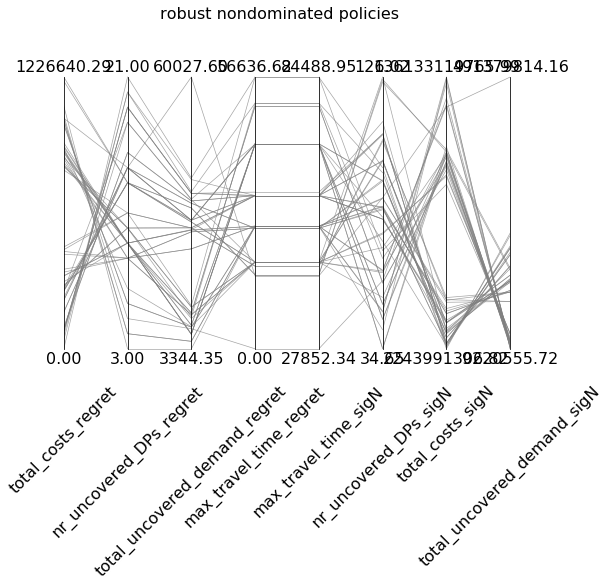

In [76]:
if len(robust_nondominated_policies) ==0:
    print("something went wrong")
elif len(robust_nondominated_policies) == 1:
    print(robust_nondominated_policies)
else:
    temp_cols = ["pol_i"]+list(all_robustness_scores.columns)

    df_temp = pd.DataFrame(robust_nondominated_policies, columns=temp_cols).set_index("pol_i")

    plot_optimal(df_temp, all_robustness_scores.columns, "robust nondominated policies")

In [77]:
df_temp = df_temp[[
    'total_costs_regret', 'total_costs_sigN', 'nr_uncovered_DPs_regret',
    'nr_uncovered_DPs_sigN', 'total_uncovered_demand_regret',
    'total_uncovered_demand_sigN', 'max_travel_time_regret',
    'max_travel_time_sigN'
]]

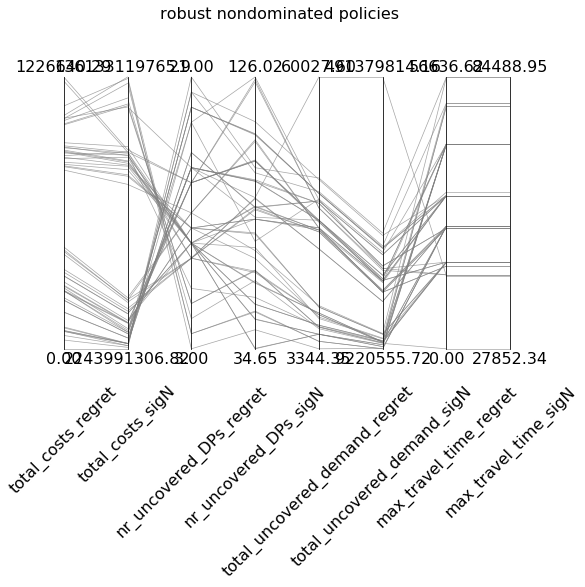

In [78]:
plot_optimal(df_temp, df_temp.columns, "robust nondominated policies")

In [79]:
np.asarray(robust_nondominated_policies)[:,0]

array(['12', '48', '51', '58', '93', '123', '343', '375', '378', '383',
       '514', '518', '540', '543', '548', '554', '569', '636', '670',
       '673', '686', '1588', '1595', '1827', '1833', '1836', '1839',
       '1850', '1865', '1868', '1869', '1870', '1873', '1875', '1879',
       '1886', '1891', '1894', '1896', '1903', '1995', '1998', '2011',
       '2012', '2019', '2054', '2055', '2066', '2067', '2068', '2071',
       '2073', '2074', '2100', '3633'], dtype='<U18')

In [80]:
rob_nondom_i = np.asarray(robust_nondominated_policies)[:,0]

In [81]:
rob_nondom_pols = np.array(All_optional_pols)[rob_nondom_i.astype(int)]

In [82]:
import pickle

# Store data (serialize)
with open('{}/MOO/rob_nondom_pols_test2.pickle'.format(case),
          'wb') as handle:
    pickle.dump(
        (rob_nondom_pols),
        handle,
        protocol=pickle.HIGHEST_PROTOCOL)

# Next iteration Framework